### Data generating process and issues

Suppose that the data are generated by the process:
$$
y_{i}=\beta_{1}+\beta_{2} x_{2 i}+\beta_{3} x_{3 i}+\varepsilon_{i}
$$
where $\varepsilon_{i}$ are iid disturbances that are uncorrelated with the regressors $x_{2}$ and $x_{3} .$ Suppose that the regressors $x_{2}$ and $x_{3}$ are positively correlated and that there exists a variable $z$ which is correlated with $x_{2}$ but uncorrelated with $x_{3} .$ We are interested in the relation between $y$ and $x_{2},$ but $x_{3}$ is unobserved and thus omitted from the estimated model. We consider two scenarios:

1. Estimation of the restricted model $y_{i}=\beta_{1}+\beta_{2} x_{2 i}+\varepsilon_{i}$ using OLS, and

2. Estimation of the restricted model $y_{i}=\beta_{1}+\beta_{2} x_{2 i}+\varepsilon_{i}$ using Two-Stage Least Squares (2SLS) with $z$ as instrument.


### Objective


To analyze the properties of the OLS and $2 \mathrm{SLS}$ estimator of $\beta_{2}$ we perform a simulation study. Consider three sample sizes: $n=10, n=100,$ and $n=1000 .$ For each sample size construct data using the following DGP with $\beta_{1}=\beta_{2}=\beta_{3}=1$
$$
\begin{aligned}
y_{i} &=1+x_{2 i}+x_{3 i}+\varepsilon_{i} \\
x_{2 i} &=x_{3 i}+z_{i}+\eta_{i}
\end{aligned}
$$
where $x_{3 i}, z_{i}, \varepsilon_{i},$ and $\eta_{i}$ are independent and distributed as $\mathcal{N}(0,1) .$ Estimate the restricted model using OLS and $2 \mathrm{SLS},$ respectively, and store the estimates of $\beta_{2} .$ Repeat this 10,000 times and calculate the average and standard deviation of the estimates. Comment on the results.


### Solution

To solve this problem, we first need to introduce and obtain analytical expression for 2SLS. After this we can just complete the simulation experiment using the random number generators and linear-algebra tools from NumPy and thus solve the probrem stated above.

__Two-Stage Least Squares__

The IV estimator can also be obtained by a Two-Stage Least Squares $(2 S L S)$ procedure. As the name suggests, this involves running two OLS regressions in a sequence. The first regression we run is a multivariate regression: Suppose $\boldsymbol{Y}$ is an $n \times p$ matrix of $p$ dependent variables. 

If we regress $\boldsymbol{Y}$ on $\boldsymbol{X},$ we obtain the $k \times p$ matrix of coefficients: $$ \hat{\boldsymbol{\beta}}=\left(\mathbf{X}^{\prime} \mathbf{X}\right)^{-1} \mathbf{X}^{\prime} \mathbf{Y} $$ We can then find the matrix of fitted values as $\hat{\mathbf{Y}}=\mathbf{X} \hat{\boldsymbol{\beta}}$


1. Run a multivariate regression of $\boldsymbol{X}$ on $\boldsymbol{Z}$ to obtain a matrix of fitted values $\widehat{\mathbf{X}}$ :
$$
\hat{\mathbf{X}}=\mathbf{Z}\left(\mathbf{Z}^{\prime} \mathbf{Z}\right)^{-1} \mathbf{Z}^{\prime} \mathbf{X}
$$

2. Regress $\boldsymbol{Y}$ on $\boldsymbol{\hat{X}}$ to obtain the IV estimator:
$$
\begin{aligned}
\hat{\boldsymbol{\beta}}_{I V} &=\left(\hat{\mathbf{X}}^{\prime} \hat{\mathbf{X}}\right)^{-1} \hat{\mathbf{X}}^{\prime} \mathbf{Y}
\end{aligned}
$$

In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Styling
plt.style.use('ggplot')

In [2]:
# data from problem
simulations = 10000
samples = [10, 100, 1000]

In [3]:
def fit_ols(X_matrix, y_vector):
    return np.linalg.multi_dot([np.linalg.inv(np.dot(X_matrix.T, X_matrix)), X_matrix.T, y_vector.T])


def fit_2sls(Z_matrix, X_matrix, y_vector):
    X_hat = np.linalg.multi_dot([Z_matrix, np.linalg.inv(np.dot(Z_matrix.T, Z_matrix)), Z_matrix.T, X_matrix])
    return fit_ols(X_hat, y_vector)
    

def simulate(n):
    # data generation - draws from normal distribution
    x_3 = np.random.normal(0, 1, sample)
    z = np.random.normal(0, 1, sample)
    epsilon = np.random.normal(0, 1, sample)
    eta = np.random.normal(0, 1, sample)

    # data generating process
    x_2 = x_3 + z + eta
    y = np.ones(sample) + x_2 + x_3 + epsilon

    # fit OLS
    X_mat = np.vstack((np.ones(sample), x_2)).T
    beta_hats_ols = fit_ols(X_mat, y)

    # fit 2SLS
    Z_mat = np.vstack((np.ones(sample), z)).T       
    beta_hats_2sls = fit_2sls(Z_mat, X_mat, y)
    
    return {'OLS': beta_hats_ols,
            '2SLS': beta_hats_2sls}

In [4]:
# placeholder for simulation data
data_store = {'OLS': {value: np.ones((1,2)) for value in samples},
              '2SLS': {value: np.ones((1,2)) for value in samples}}

# run simulation for each sample size
for sample in samples:
    
    for sim in range(simulations):  # run 10.000 times
        s = simulate(sample)
        
        # save results in dictionary
        data_store['OLS'][sample] = np.vstack((data_store['OLS'][sample], s['OLS']))
        data_store['2SLS'][sample] = np.vstack((data_store['2SLS'][sample], s['2SLS']))
    
    # drop first entries in data_store vectors
    data_store['OLS'][sample] = data_store['OLS'][sample][1:]
    data_store['2SLS'][sample] = data_store['2SLS'][sample][1:]

In [5]:
# calculate descriptive statistics for data
def metrics(array):
    return {
        'mu': np.mean(array),
        'sigma': np.std(array)
    }

# make pretty output using pandas
def prettify(model):
    results = {}

    for key in data_store[model].keys():
        alpha_arr = data_store[model][key][:,0]
        beta_arr = data_store[model][key][:,1]

        alpha_metrics = metrics(alpha_arr)
        beta_metrics = metrics(beta_arr)

        results.update({
            (f'n = {key}', 'alpha'): alpha_metrics,
            (f'n = {key}', 'beta'): beta_metrics
        })
    
    return pd.DataFrame(results)
    
print('OLS results:')
display(prettify('OLS'))
print('\n\n2SLS results:')
display(prettify('2SLS'))

OLS results:


n = 10             n = 100            n = 1000          
          alpha      beta     alpha      beta     alpha      beta
mu     1.000759  1.336335  1.000386  1.333505  1.000080  1.332820
sigma  0.436106  0.284606  0.128586  0.075217  0.040895  0.023481



2SLS results:


n = 10              n = 100            n = 1000          
          alpha       beta     alpha      beta     alpha      beta
mu      0.92065   0.771548  0.999928  0.987038  1.000035  0.998414
sigma  12.36883  19.582701  0.143243  0.150132  0.044720  0.044752

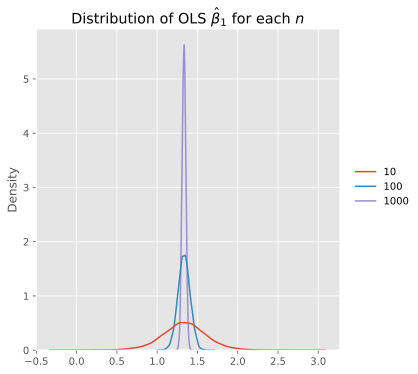

In [6]:
# data visualizations
for sample in samples:
    data_store['OLS'][sample] = data_store['OLS'][sample][:,1]

sns.displot(data=data_store['OLS'], kind="kde")

plt.title(r'Distribution of OLS $\hat{\beta}_1$ for each $n$')

plt.show()

### Conclusion

As we would have assumed we get more consistent estimates in terms of a decreasing $\sigma$ for both regression models as n increases (10, 100, 1000).

However there is obviously a large (positive) bias when using OLS and not using the instumental regression _($E(\beta_1)$ deviates from true value of 1)_.

We see that $\beta$ goes towards the true value of 1 in the 2SLS case - thus this model is somewhat more exact. We see that instumental variables in Two-Stage Least Squares is _unbiased_ and OLS provides _biased_ estimates in the case of this particular data generating process.